In [1]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
print(torch.cuda.is_available())

import matplotlib.pyplot as plt
%matplotlib inline
torch.manual_seed(32)

True


In [2]:
# Load data
loaded_trajectory_pos = np.load('trajectory_pos.npy', allow_pickle=True)
N_STEPS = len(loaded_trajectory_pos)
NUM_PARTICLES = loaded_trajectory_pos[0].shape[0]
LX = 5. # BOX WIDTH
LY = 5.  # BOX HEIGHT
DEG_FREED = 2 # degrees of freedom, here x and y coordinates
NUM_FEATURES = NUM_PARTICLES * DEG_FREED
print('N_STEPS =', N_STEPS)
print('NUM_PARTICLES =', NUM_PARTICLES)
print('DEG_FREED =', DEG_FREED)
print(loaded_trajectory_pos.shape)

N_STEPS = 1001
NUM_PARTICLES = 12
DEG_FREED = 2
(1001, 12, 2)


In [3]:
# Data preparation
#input T0 is the time step t; output T1 the time step t+1
sequence = loaded_trajectory_pos/LX
#all values are betwenn 0 and 1
print(sequence.shape)
print(np.max(sequence))
print(np.min(sequence))

(1001, 12, 2)
0.9998995337032556
5.122800017431927e-06


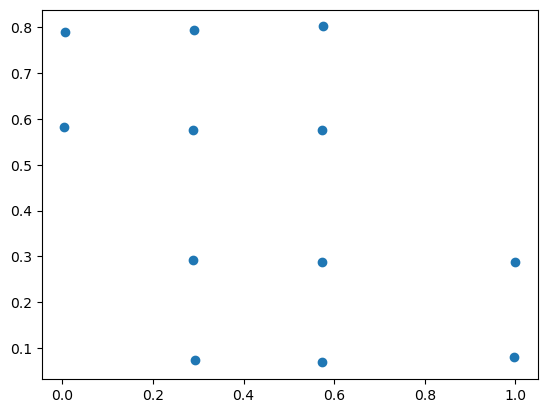

In [4]:
#trajectory[t,n,i]
#t-> time step
#n-> particle
#i-> x or y coordinate
t = 18 #time step
plt.scatter(sequence[t,:,0], sequence[t,:,1], marker='o')

In [5]:
def calculate_periodic_increments(sequence_tensor, LX=1.0, LY=1.0):
    """
    Calculate increments between positions at consecutive timesteps,
    accounting for periodic boundary conditions.

    Parameters:
    - sequence_tensor: A tensor of shape [N_STEPS, n_atoms, 2] containing positions at each timestep.
    - LX, LY: The sizes of the computational box in the x and y dimensions.

    Returns:
    - A tensor of shape [N_STEPS-1, n_atoms, 2] containing the increments, adjusted for periodic boundaries.
    """
    # Calculate raw increments
    raw_increments = sequence_tensor[1:, :, :] - sequence_tensor[:-1, :, :]

    # Apply periodic boundary conditions for wrapping around the box
    increments_x = raw_increments[:, :, 0]
    increments_y = raw_increments[:, :, 1]

    increments_x = torch.where(increments_x > LX / 2, increments_x - LX, increments_x)
    increments_x = torch.where(increments_x < -LX / 2, increments_x + LX, increments_x)

    increments_y = torch.where(increments_y > LY / 2, increments_y - LY, increments_y)
    increments_y = torch.where(increments_y < -LY / 2, increments_y + LY, increments_y)

    # Combine adjusted increments
    adjusted_increments = torch.stack([increments_x, increments_y], dim=-1)

    return adjusted_increments

In [6]:
#Data preparation
sequence_tensor = torch.tensor(sequence, dtype=torch.float32)
#input is 'sequence_tensor' positions at timestep t;
#output is 'increments' difference between timestep t and timestep t+1
increment_tensor = calculate_periodic_increments(sequence_tensor)
print(increment_tensor.shape)
#check
time = 18
atom = 1
print(sequence_tensor[time+1, atom, 0]-sequence_tensor[time, atom, 0])
print(increment_tensor[time, atom, 0])
print('ave increment,',torch.mean(torch.abs(increment_tensor)))

torch.Size([1000, 12, 2])
tensor(-0.9999)
tensor(0.0001)
ave increment, tensor(0.0008)


In [7]:
MAX_INCR = 0.0016

#I don't need the last timestep anymore for training
current_timestep = sequence_tensor[1:, :, :]
previous_timestep = sequence_tensor[:-1, :, :]
input_sequence = torch.cat((current_timestep, previous_timestep), dim=2)
#from [:, :, 0:2] is the current time step, from [:, :, 3:4] is the previous one
output_sequence = increment_tensor/MAX_INCR
print('input size', input_sequence.shape)
print('output size', output_sequence.shape)

input size torch.Size([1000, 12, 4])
output size torch.Size([1000, 12, 2])


In [8]:
class PeriodicPairwiseDistanceLayer(nn.Module):
    def __init__(self, lx=1.0, ly=1.0):
        super(PeriodicPairwiseDistanceLayer, self).__init__()
        self.lx = lx
        self.ly = ly

    def forward(self, positions):
        with torch.no_grad():  # Ensure computations within do not track gradients
            # positions is expected to be of shape [batch_size, n_atoms, degrees of freedom]
            
            n_atoms = positions.size(1)
            
            # Calculate pairwise differences between atoms
            diff_x = positions[:, :, 0:1] - positions[:, :, 0:1].transpose(1, 2)
            diff_y = positions[:, :, 1:2] - positions[:, :, 1:2].transpose(1, 2)
            
            # Apply periodic boundary conditions for wrapping around the box
            diff_x = torch.where(diff_x > self.lx / 2, diff_x - self.lx, diff_x)
            diff_x = torch.where(diff_x < -self.lx / 2, diff_x + self.lx, diff_x)
            
            diff_y = torch.where(diff_y > self.ly / 2, diff_y - self.ly, diff_y)
            diff_y = torch.where(diff_y < -self.ly / 2, diff_y + self.ly, diff_y)
            
            # Calculate squared distances with periodic boundary conditions
            squared_distances = diff_x**2 + diff_y**2
            
            # Take the square root to get distances
            distances = torch.sqrt(squared_distances)
            
            # Create a mask for the batch
            mask = ~torch.eye(n_atoms, dtype=torch.bool, device=positions.device)
            # Expand mask to match batch size
            mask = mask.unsqueeze(0).expand(positions.size(0), n_atoms, n_atoms)
            
            # Apply mask and reshape
            distances = distances[mask].reshape(positions.size(0), n_atoms, n_atoms-1)
            
            # Flatten the distances to get a vector of size [batch_size, n_atom*(n_atom-1)]
            rij = distances.view(positions.size(0), -1)
            
            return rij

In [9]:
def get_atom_pair_from_index(index, n_atoms=NUM_PARTICLES):
    """
    Given an index in the flattened distance vector rij, returns the pair of atoms (i, j)
    whose distance is represented at that index.
    
    Parameters:
    - index: The index in the flattened distance vector rij.
    - n_atoms: The total number of atoms (default is 12).
    
    Returns:
    - A tuple (i, j) representing the pair of atoms.
    """
    # Calculate the total number of distances per atom (excluding self-distance)
    distances_per_atom = n_atoms - 1
    # Determine the atom index that the distance originates from
    atom_i = index // distances_per_atom  
    # Determine the relative index of the second atom in the distances from atom_i
    relative_index_j = index % distances_per_atom
    # Adjust the second atom's index to account for the exclusion of self-distance
    atom_j = relative_index_j if relative_index_j < atom_i else relative_index_j + 1
    return (atom_i, atom_j)

# Example usage
#index = 23
#atom_pair = get_atom_pair_from_index(index)
#print(f"The distance at index {index} corresponds to the distance between atoms {atom_pair[0]} and {atom_pair[1]}")


In [10]:
# Example
periodic_pairwise_distance_layer = PeriodicPairwiseDistanceLayer()
rij = periodic_pairwise_distance_layer(sequence_tensor)

print(rij.shape) 

torch.Size([1001, 132])


In [11]:
print(sequence[0])

[[9.98708318e-01 3.79703117e-04]
 [9.99524215e-01 2.87875238e-01]
 [1.17029500e-03 5.78844333e-01]
 [1.18053607e-03 8.67094246e-01]
 [2.90126874e-01 5.62733956e-04]
 [2.88161566e-01 2.89898231e-01]
 [2.88877631e-01 5.76491537e-01]
 [2.89418842e-01 8.66254915e-01]
 [5.76777029e-01 1.84673660e-03]
 [5.76052324e-01 2.88421938e-01]
 [5.76509187e-01 5.76183826e-01]
 [5.77362904e-01 8.65782173e-01]]


In [12]:
print(rij[0])

tensor([0.2875, 0.4215, 0.1333, 0.2914, 0.4094, 0.5137, 0.3202, 0.4219, 0.5115,
        0.5985, 0.4423, 0.2875, 0.2910, 0.4208, 0.4087, 0.2886, 0.4087, 0.5117,
        0.5104, 0.4235, 0.5119, 0.5970, 0.4215, 0.2910, 0.2882, 0.5112, 0.4073,
        0.2877, 0.4071, 0.5992, 0.5148, 0.4247, 0.5118, 0.1333, 0.4208, 0.2882,
        0.3183, 0.5110, 0.4089, 0.2882, 0.4453, 0.5985, 0.5148, 0.4238, 0.2914,
        0.4087, 0.5112, 0.3183, 0.2893, 0.4241, 0.1343, 0.2867, 0.4057, 0.5120,
        0.3173, 0.4094, 0.2886, 0.4073, 0.5110, 0.2893, 0.2866, 0.4236, 0.4078,
        0.2879, 0.4063, 0.5133, 0.5137, 0.4087, 0.2877, 0.4089, 0.4241, 0.2866,
        0.2898, 0.5136, 0.4068, 0.2876, 0.4085, 0.3202, 0.5117, 0.4071, 0.2882,
        0.1343, 0.4236, 0.2898, 0.3177, 0.5103, 0.4081, 0.2879, 0.4219, 0.5104,
        0.5992, 0.4453, 0.2867, 0.4078, 0.5136, 0.3177, 0.2866, 0.4257, 0.1361,
        0.5115, 0.4235, 0.5148, 0.5985, 0.4057, 0.2879, 0.4068, 0.5103, 0.2866,
        0.2878, 0.4226, 0.5985, 0.5119, 

In [13]:
index = 23
atom_pair = get_atom_pair_from_index(index)
print(f"The distance at index {index} corresponds to the distance between atoms {atom_pair[0]} and {atom_pair[1]}")
print('The distance is ', rij[0,index].item())

The distance at index 23 corresponds to the distance between atoms 2 and 1
The distance is  0.2909737229347229


In [14]:
#Check the distance layer
atom_1 = 2
atom_2 = 1
x1 = sequence[0,atom_1,0]
y1 = sequence[0,atom_1,1]
x2 = sequence[0,atom_2,0]
y2 = sequence[0,atom_2,1]
print('x1= ', x1)
print('y1= ', y1)
print('x2= ', x2)
print('y2= ', y2)
diff_x = (x1-x2)+1.
diff_y = (y1-y2)
print('diff_x= ', diff_x)
print('diff_y= ', diff_y)
print('dist= ', np.sqrt(diff_x**2+diff_y**2))

x1=  0.0011702949975489446
y1=  0.5788443327421195
x2=  0.9995242150924186
y2=  0.28787523819141925
diff_x=  0.0016460799051303265
diff_y=  0.2909690945507003
dist=  0.29097375064206127


In [15]:
class MolecularDynamicsModel(nn.Module):
    def __init__(self, n_atoms=NUM_PARTICLES, n_layers=5, hidden_dim=24*24, lx=1.0, ly=1.0):
        super(MolecularDynamicsModel, self).__init__()
        self.n_atoms = n_atoms
        self.pairwise_distance_layer = PeriodicPairwiseDistanceLayer(lx, ly)
        
        # Adjust the input dimension for the first linear layer
        # It includes the pairwise distances and the previous timestep coordinates
        input_dim = n_atoms * (n_atoms - 1) + 2 * n_atoms
        
        self.linear_layers = nn.ModuleList()
        self.linear_layers.append(nn.Linear(input_dim, hidden_dim))
        for i in range(n_layers - 1):
            self.linear_layers.append(nn.Linear(hidden_dim, hidden_dim))
        
        self.final_layer = nn.Linear(hidden_dim, n_atoms * 2)
        
    def forward(self, input_sequence):
        # Split the input_sequence into current and previous timestep coordinates
        current_timestep = input_sequence[:, :, :2]
        previous_timestep = input_sequence[:, :, 2:]
    
        # Compute pairwise distances for the current timestep
        rij = self.pairwise_distance_layer(current_timestep)
    
        # Flatten rij to match the batch dimension for concatenation
        rij_flat = rij.view(input_sequence.shape[0], -1)
    
        # Concatenate rij with the flattened previous timestep coordinates
        # Use .reshape() instead of .view() for previous_timestep
        combined_input = torch.cat((rij_flat, previous_timestep.reshape(input_sequence.shape[0], -1)), dim=1)
    
        # Pass through linear layers with ReLU activations
        x = combined_input
        for layer in self.linear_layers:
            x = F.relu(layer(x))
    
        # Get the final output without applying ReLU
        output = self.final_layer(x)
    
        # Reshape the output to match [batch_size, n_atoms, 2]
        output = output.view(-1, self.n_atoms, 2)
    
        return output

        #the output is the incremental Dx and Dy

In [16]:
model = MolecularDynamicsModel()
model(input_sequence[0].unsqueeze(0))

tensor([[[ 0.0237,  0.0253],
         [ 0.0056,  0.0184],
         [-0.0213, -0.0022],
         [-0.0237,  0.0466],
         [ 0.0079, -0.0254],
         [ 0.0008,  0.0269],
         [-0.0315, -0.0147],
         [ 0.0205, -0.0126],
         [-0.0359, -0.0215],
         [ 0.0215,  0.0251],
         [-0.0472, -0.0104],
         [ 0.0292, -0.0180]]], grad_fn=<ViewBackward0>)

In [17]:
def permute_particles(x, y, n_particles):
    # Generate a random permutation
    perm = torch.randperm(n_particles)
    # Apply the permutation
    x_permuted = x[:, perm, :]
    y_permuted = y[:, perm, :]
    return x_permuted, y_permuted

In [18]:
def mini_batch(device, data_loader, step_fn, should_permute = False):
    mini_batch_losses = []
    for x_batch, y_batch in data_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        if should_permute:
            x_batch, y_batch = permute_particles(x_batch, y_batch, n_particles=NUM_PARTICLES)
        mini_batch_loss = step_fn(x_batch, y_batch)
        mini_batch_losses.append(mini_batch_loss)

    loss = np.mean(mini_batch_losses)
    return loss

In [19]:
# Builds dataset containing ALL (unflatten) data points
#input: sequence_tensor
#output: increment_tensor
dataset = TensorDataset(input_sequence, output_sequence)

# Performs the split
ratio = .8
n_total = len(dataset)
n_train = int(n_total * ratio)
n_val = n_total - n_train

train_data, val_data = random_split(dataset, [n_train, n_val])

first_val_element = val_data[0]
print("First element of train_data:")
print("Input (sequence_tensor):", first_val_element[0])
print("Output (increment_tensor):", first_val_element[1])

First element of train_data:
Input (sequence_tensor): tensor([[0.0059, 0.9724, 0.0063, 0.9725],
        [0.1436, 0.2692, 0.1430, 0.2689],
        [0.9022, 0.7911, 0.8996, 0.7922],
        [0.8568, 0.1224, 0.8559, 0.1221],
        [0.3747, 0.5658, 0.3749, 0.5653],
        [0.0525, 0.5362, 0.0512, 0.5361],
        [0.1216, 0.7538, 0.1231, 0.7551],
        [0.5848, 0.5159, 0.5855, 0.5156],
        [0.6032, 0.2568, 0.6025, 0.2559],
        [0.3157, 0.1344, 0.3168, 0.1349],
        [0.7927, 0.6142, 0.7937, 0.6131],
        [0.6981, 0.8481, 0.6993, 0.8484]])
Output (increment_tensor): tensor([[-0.2494, -0.0552],
        [ 0.3729,  0.1840],
        [ 1.5999, -0.6872],
        [ 0.5651,  0.1748],
        [-0.1250,  0.3199],
        [ 0.8069,  0.0139],
        [-0.9200, -0.8051],
        [-0.4485,  0.1772],
        [ 0.4289,  0.5525],
        [-0.7059, -0.3115],
        [-0.6226,  0.7236],
        [-0.7102, -0.1675]])


In [20]:
permute_particles(first_val_element[0].unsqueeze(0), first_val_element[1].unsqueeze(0), NUM_PARTICLES)

(tensor([[[0.6981, 0.8481, 0.6993, 0.8484],
          [0.3747, 0.5658, 0.3749, 0.5653],
          [0.8568, 0.1224, 0.8559, 0.1221],
          [0.9022, 0.7911, 0.8996, 0.7922],
          [0.6032, 0.2568, 0.6025, 0.2559],
          [0.0059, 0.9724, 0.0063, 0.9725],
          [0.3157, 0.1344, 0.3168, 0.1349],
          [0.5848, 0.5159, 0.5855, 0.5156],
          [0.0525, 0.5362, 0.0512, 0.5361],
          [0.1436, 0.2692, 0.1430, 0.2689],
          [0.1216, 0.7538, 0.1231, 0.7551],
          [0.7927, 0.6142, 0.7937, 0.6131]]]),
 tensor([[[-0.7102, -0.1675],
          [-0.1250,  0.3199],
          [ 0.5651,  0.1748],
          [ 1.5999, -0.6872],
          [ 0.4289,  0.5525],
          [-0.2494, -0.0552],
          [-0.7059, -0.3115],
          [-0.4485,  0.1772],
          [ 0.8069,  0.0139],
          [ 0.3729,  0.1840],
          [-0.9200, -0.8051],
          [-0.6226,  0.7236]]]))

In [21]:
# Builds a loader of each set
train_loader = DataLoader(dataset=train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=16)
for inputs, targets in val_loader:
    print("First batch from train_loader:")
    print("Inputs:", inputs[0])
    print("Targets:", targets[0])
    break

First batch from train_loader:
Inputs: tensor([[0.0059, 0.9724, 0.0063, 0.9725],
        [0.1436, 0.2692, 0.1430, 0.2689],
        [0.9022, 0.7911, 0.8996, 0.7922],
        [0.8568, 0.1224, 0.8559, 0.1221],
        [0.3747, 0.5658, 0.3749, 0.5653],
        [0.0525, 0.5362, 0.0512, 0.5361],
        [0.1216, 0.7538, 0.1231, 0.7551],
        [0.5848, 0.5159, 0.5855, 0.5156],
        [0.6032, 0.2568, 0.6025, 0.2559],
        [0.3157, 0.1344, 0.3168, 0.1349],
        [0.7927, 0.6142, 0.7937, 0.6131],
        [0.6981, 0.8481, 0.6993, 0.8484]])
Targets: tensor([[-0.2494, -0.0552],
        [ 0.3729,  0.1840],
        [ 1.5999, -0.6872],
        [ 0.5651,  0.1748],
        [-0.1250,  0.3199],
        [ 0.8069,  0.0139],
        [-0.9200, -0.8051],
        [-0.4485,  0.1772],
        [ 0.4289,  0.5525],
        [-0.7059, -0.3115],
        [-0.6226,  0.7236],
        [-0.7102, -0.1675]])


In [22]:
def make_train_step_fn(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def perform_train_step_fn(x, y):
        # Sets model to TRAIN mode
        model.train()
        # Step 1 - Computes our model's predicted output - forward pass
        yhat = model(x)
        # Step 2 - Computes the loss
        loss = loss_fn(yhat, y)
        # Step 3 - Computes gradients
        loss.backward()
        # Step 4 - Updates parameters using gradients and the learning rate
        optimizer.step()
        optimizer.zero_grad()     
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return perform_train_step_fn

def make_val_step_fn(model, loss_fn):
    # Builds function that performs a step in the validation loop
    def perform_val_step_fn(x, y):
        # Sets model to EVAL mode
        model.eval()     
        # Step 1 - Computes our model's predicted output - forward pass
        yhat = model(x)
        # Step 2 - Computes the loss
        loss = loss_fn(yhat, y)
        # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
        return loss.item()
    
    return perform_val_step_fn

In [23]:
# Training loop Configuration

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = MolecularDynamicsModel()
model.to(device)
# Defines an optimizer to update the parameters  retrieved directly from the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Defines a MSE loss function
loss_fn = nn.MSELoss()

# Creates the train_step function for our model, loss function and optimizer
train_step_fn = make_train_step_fn(model, loss_fn, optimizer)

# Creates the val_step function for our model and loss function
val_step_fn = make_val_step_fn(model, loss_fn)

In [24]:
#Training no permutation
n_epochs = 401
losses = []
val_losses = []

for epoch in range(n_epochs):
    # inner loop
    loss = mini_batch(device, train_loader, train_step_fn, should_permute = False)
    losses.append(loss)  
    # VALIDATION
    # no gradients in validation!
    with torch.no_grad():
        val_loss = mini_batch(device, val_loader, val_step_fn)
        val_losses.append(val_loss)
    if epoch % (n_epochs//5) == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.3f} | Val loss: {val_loss:.3f}")

Epoch: 0 | Train loss: 0.345 | Val loss: 1.088
Epoch: 80 | Train loss: 0.029 | Val loss: 0.730
Epoch: 160 | Train loss: 0.021 | Val loss: 0.733
Epoch: 240 | Train loss: 0.024 | Val loss: 0.708
Epoch: 320 | Train loss: 0.012 | Val loss: 0.700
Epoch: 400 | Train loss: 0.009 | Val loss: 0.709


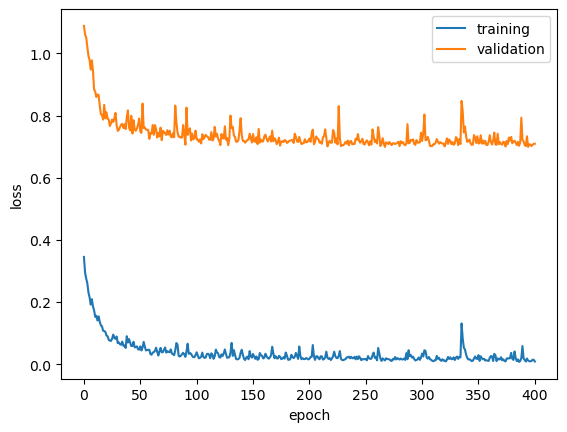

In [25]:
plt.plot(losses, label = 'training')
plt.plot(val_losses, label = 'validation')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [26]:
def Wrap_bc(positions, lx=1., ly=1.):
    # Wrap positions based on the periodic boundary conditions
    positions[:,0] = positions[:, 0] % lx
    positions[:,1] = positions[:, 1] % ly
    return positions

(1001, 12, 2)
(1001, 12, 2)


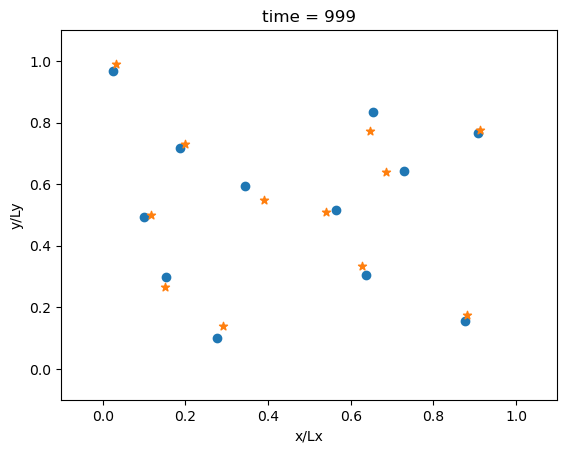

In [27]:
#compare full trajectories step-by-step
real_xy = np.zeros_like(sequence)
predicted_xy = np.zeros_like(sequence)
real_xy[0] = sequence[0]
predicted_xy[0] = sequence[0]
real_xy[1] = sequence[1]
predicted_xy[1] = sequence[1]
model.eval()
for i in range(2, len(sequence)):
    # Concatenate sequence[i-1] and sequence[i-2] to form the new input
    new_input = np.concatenate((sequence[i-1], sequence[i-2]), axis=-1) 
    new_input_tensor = torch.from_numpy(new_input).float().unsqueeze(0)
    with torch.inference_mode(): predicted_t = model(new_input_tensor.to(device))*MAX_INCR
    real_xy[i] = sequence[i]
    predicted_xy[i] = predicted_xy[i-1] + predicted_t.cpu().numpy() # the output is the increment
    predicted_xy[i] =  Wrap_bc(predicted_xy[i], lx=1., ly=1.)
    
print(real_xy.shape)
print(predicted_xy.shape)
time = 999
plt.scatter(real_xy[time,:,0], real_xy[time,:,1], marker='o')
plt.scatter(predicted_xy[time,:,0], predicted_xy[time,:,1], marker='*')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('time = ' + str(time))
plt.xlabel('x/Lx')
plt.ylabel('y/Ly')
plt.show()

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

def make_video(real_y, pred_y, file_name):
    # Update function for the animation
    def update(frame_number, real_y, pred_y, scatter_real, scatter_pred, time_text):
        # Update the data of both scatter plots for the new frame
        scatter_real.set_offsets(real_y[frame_number])
        scatter_pred.set_offsets(pred_y[frame_number])
        # Update the time annotation
        time_text.set_text(f'Time = {frame_number}')
    
    # Set up the figure, the axis, and the plot elements we want to animate
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([-0.1, 1.1])
    ax.set_xlabel('x/Lx')
    ax.set_ylabel('y/Ly')    
    # Create initial scatter plots and a text annotation
    scatter_real = ax.scatter(real_y[0, :, 0], real_y[0, :, 1], color='blue', marker='o')
    scatter_pred = ax.scatter(pred_y[0, :, 0], pred_y[0, :, 1], color='orange', marker='*')
    time_text = ax.text(0.5, 1.05, '', transform=ax.transAxes, ha='center')
    
    # Create the animation using FuncAnimation
    ani = FuncAnimation(fig, update, frames=len(real_y), fargs=(real_y, pred_y, scatter_real, scatter_pred, time_text), interval=100)
    
    # Save the animation
    ani.save(file_name, writer='ffmpeg')
    
    # Convert the animation to an HTML5 video embedded in the notebook
    html = HTML(ani.to_html5_video())
    
    # Close the figure to prevent it from displaying in the notebook or script output
    plt.close(fig)
    
    # Return the HTML object to display the animation in the notebook
    return html

In [29]:
make_video(real_xy, predicted_xy, file_name = 'predicted_minimal.mp4')

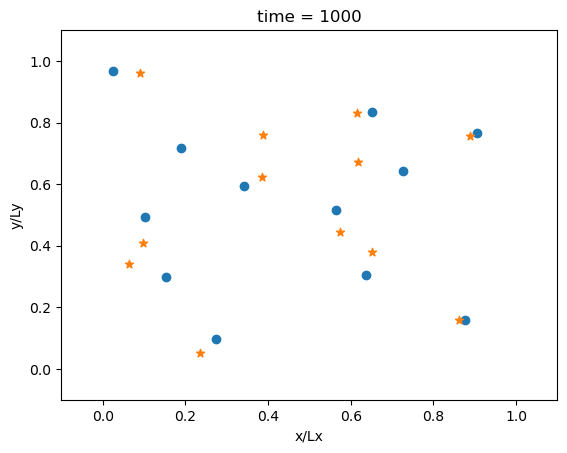

In [30]:
#compare full trajectories fully predicted 
fully_predicted_xy = np.zeros_like(sequence)
fully_predicted_xy[0] = sequence[0]
fully_predicted_xy[1] = sequence[1]
model.eval()
for i in range(2, len(sequence)):
    new_input = np.concatenate((fully_predicted_xy[i-1], fully_predicted_xy[i-2]), axis=-1) 
    new_input_tensor = torch.from_numpy(new_input).float().unsqueeze(0)
    with torch.inference_mode(): predicted_t = model(new_input_tensor.to(device))*MAX_INCR
    fully_predicted_xy[i] = fully_predicted_xy[i-1] + predicted_t.cpu().numpy()
    fully_predicted_xy[i] =  Wrap_bc(fully_predicted_xy[i], lx=1., ly=1.)
time = 1000
plt.scatter(real_xy[time,:,0], real_xy[time,:,1], marker='o')
plt.scatter(fully_predicted_xy[time,:,0], fully_predicted_xy[time,:,1], marker='*')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('time = ' + str(time))
plt.xlabel('x/Lx')
plt.ylabel('y/Ly')
plt.show()

In [31]:
# Calculate squared differences for x and y coordinates
d1 = ((real_xy[:, :, 0] - predicted_xy[:, :, 0])**2) + ((real_xy[:, :, 1] - predicted_xy[:, :, 1])**2)
d2 = ((real_xy[:, :, 0] - fully_predicted_xy[:, :, 0])**2) + ((real_xy[:, :, 1] - fully_predicted_xy[:, :, 1])**2)
# Sum the errors for all particles at each time step
overall_error_per_timestep1 = np.sum(d1, axis=1)
overall_error_per_timestep2 = np.sum(d2, axis=1)

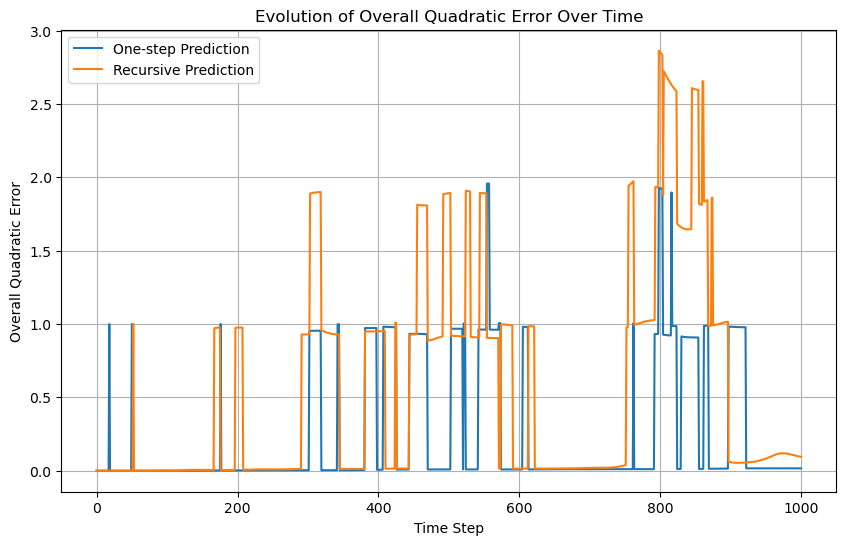

In [32]:
time_steps = np.arange(len(overall_error_per_timestep1))

plt.figure(figsize=(10, 6))
plt.plot(time_steps, overall_error_per_timestep1, label='One-step Prediction')
plt.plot(time_steps, overall_error_per_timestep2, label='Recursive Prediction')
plt.xlabel('Time Step')
plt.ylabel('Overall Quadratic Error')
plt.title('Evolution of Overall Quadratic Error Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
make_video(real_xy, fully_predicted_xy, file_name = 'fully_predicted.mp4')